In [1]:
import metmhn.Utilityfunctions as utils
import metmhn.regularized_optimization as reg_opt

import pandas as pd
import numpy as np
import jax as jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, roc_auc_score, 
                             precision_recall_curve)
from sklearn.linear_model import LogisticRegression
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

Read the data and split it in  training and test sets:

In [2]:
mut_handle = "../data/paad/G12_PAADPANET_PM_z10_Events_30and5_Full.csv"
annot_handle = "../data/paad/G12_PAADPANET_PM_z10_sampleSelection.csv"

annot_data = pd.read_csv(annot_handle)
mut_data = pd.read_csv(mut_handle)
mut_data.rename(columns={"Unnamed: 0":"patientID"}, inplace = True)
dat = pd.merge(mut_data, annot_data.loc[:, ['patientID', 'metaStatus']], on=["patientID", "patientID"])

# Remove datapoints, that consist solely of NaNs
dat = dat.loc[dat.iloc[:,1:-3].isna().all(axis=1) == False, :]
dat = dat.loc[(dat.iloc[:,1:-3].sum(axis=1) > 0), :]

In [3]:
# Split the dataset into a training and a test set
n_dat = dat.shape[0]
start = 'P.Mut.KRAS'
stop = 'M.Mut.PTPRT'
shuffled = dat.sample(frac=1)
train = shuffled.iloc[:int(0.8*n_dat), :]
test = shuffled.iloc[int(0.8*n_dat):, :]

train = train.set_index(["paired", "metaStatus"])
train = train.loc[zip(*[[0,0,0,1],["present", "absent", "isMetastasis", "isPaired"]]), start:stop]
train.loc[(0, ["present", "isMetastasis"]), "Seeding"] = 1
train.loc[(0, "absent"), "Seeding"] = 0
train.loc[(1, "isPaired"), "Seeding"] = 1
train = train.astype('int8')
train_po, train_mo, train_pm, train_c = utils.split_data(train)

test = test.set_index(["paired", "metaStatus"])
test = test.loc[zip(*[[0,0,0,1],["present", "absent", "isMetastasis", "isPaired"]]), start:stop]
test.loc[(0, ["present", "isMetastasis"]), "Seeding"] = 1
test.loc[(0, "absent"), "Seeding"] = 0
test.loc[(1, "isPaired"), "Seeding"] = 1
test = test.astype('int8')
test_po, test_mo, test_pm, test_c = utils.split_data(train)
test = np.row_stack((test_po, test_pm, test_c))

Learn the metMHN:

In [18]:
penal1 = 0.001 #L1 penalty on off-diagonals
m_p_corr = 0.5
th_init, fd_init, sd_init = utils.indep(jnp.array(train.to_numpy()), train_c.shape[0])
theta, fd_effects, sd_effects = reg_opt.learn_mhn(th_init, fd_init, sd_init, train_po, train_pm, 
                                                  train_mo, train_c, m_p_corr, penal1)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1368     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25486D+01    |proj g|=  1.62380D+00

At iterate    1    f=  1.07677D+01    |proj g|=  8.87181D-01

At iterate    2    f=  9.85037D+00    |proj g|=  1.39903D-01

At iterate    3    f=  9.69766D+00    |proj g|=  6.39289D-02

At iterate    4    f=  9.44507D+00    |proj g|=  1.13613D-01

At iterate    5    f=  9.27966D+00    |proj g|=  1.79059D-01

At iterate    6    f=  9.09239D+00    |proj g|=  1.31595D-01

At iterate    7    f=  8.92350D+00    |proj g|=  3.80361D-02

At iterate    8    f=  8.84825D+00    |proj g|=  7.93927D-02

At iterate    9    f=  8.74266D+00    |proj g|=  6.45697D-02

At iterate   10    f=  8.62303D+00    |proj g|=  6.40047D-02

At iterate   11    f=  8.60385D+00    |proj g|=  1.55994D-01

At iterate   12    f=  8.53313D+00    |proj g|=  2.19583D-02

At iterate   13    f=  8.5

Calculate the probability that a MT is present given the PT-genotype:

In [21]:
mhn_probs = reg_opt.p_unobs_seeding(theta, fd_effects, jnp.array(test))

Learn a standard logistic regression model as baseline :

In [22]:
train_labels = train.loc[:, 'Seeding']
logReg = LogisticRegression(C=1, max_iter=1000)
logReg.fit(train.iloc[:,:-1].to_numpy(), train_labels)
reg_probs = logReg.predict_proba(test[:, :-1])

Compare both models:

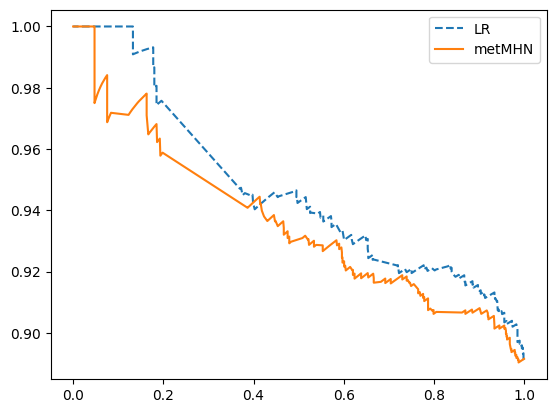

In [23]:
test_labels = test[:, -1]
mhn_auc = roc_auc_score(test_labels, mhn_probs)
mhn_fpr, mhn_tpr, _ = roc_curve(test_labels, mhn_probs)
mhn_precision, mhn_recall, _ = precision_recall_curve(test_labels, mhn_probs)

reg_auc = roc_auc_score(test_labels, reg_probs[:,1])
reg_fpr, reg_tpr, _ = roc_curve(test_labels, reg_probs[:, 1])
reg_precision, reg_recall, _ = precision_recall_curve(test_labels, reg_probs[:,1])

plt.plot(reg_recall, reg_precision, linestyle="--", label="LR")
plt.plot(mhn_recall, mhn_precision, linestyle="-", label="metMHN")
plt.legend()

In [24]:
print(reg_auc, mhn_auc)

0.6858880778588807 0.643588807785888
